# 30254 - ML for Public Policy HW5 - Nora Hajjar

## Machine Learning Pipeline Version 3 (HW5): 

The goal of this homework assignment is to use the feedback from HW3 to fix and update your ML pipeline. The assignment is to redo HW3 and submit the answers again.

HW 3 Feedback


PART 1: Pipeline (18/40)

Models (10/10)
● The models need to be implemented but also written efficiently and in a reusable manner
● You implemented different models in a modularized way, but it seems that your code in line
169-293 in your pipeline is not used when you call the model?

Model Parameters (3/10)
● It seems that your run_models function can take in different models with different parameters, but
your code in the pipeline didn’t show how it takes care of different parameters of a single model

Metrics (1/10)
● Should be calculated on % of population and not on score thresholds
● You didn’t choose the thresholds responding to how many percentage of projects will be
predicted with label 1
● In your precision and recall curve, you should plot the value of precision and recall against the
value of threshold, but you plot precision against recall. Also the threshold is not translated to the
percentile of the population

Temporal Validation (4/10)
● Leaving gap between end of training and for the labels/outcomes to happen
● Your temporal validation functions are well organized. However, you didn’t take care of the
requirement that the first posting date for test data should be 60 days after the end posting date,
since you need 60 days to know the result of the train data
● Moreover, you shouldn’t choose the start and end date of training & test data manually


PART 2: Run the code on the donors choose problem (23/40)

Prep data (0/2)
● What’s the line [54] - [65] in ipynb doing here? You need to modularize your preprocessing of the
data as functions in the pipeline. It’s confusing for the reader to see all the details and the
repetitions in your manipulation
● You shouldn’t preprocess the data before splitting the training and data set. By doing the data
imputation you violated the independency of the two sets of data

Get label (4/4)
● You corrected computed the label

Generate Features (3/4)
● You shouldn’t hardcode the categorical features that need to be converted

Training and test sets (8/10)
● You split the temporal training and test data, but they are wrong since your pipeline is wrong

Models and hyperparameters (4/10)
● The code in experiment with different parameters section in ipynb is confusing. It seems that you
are only dealing with bagging and didn’t experiment other models
● You need to modularize the experimentation on different models in the pipeline

Metrics (4/10)
● You report the evaluation with different metrics and they are wrong in your pipeline, and you
didn’t plot the precision recall curve


PART 3: Write up the results (5/10)
● You need a more comprehensive discussion about how the different models perform with respect
to different metrics
● Also it’s not clear how you explain the change of the data over time


PART 4: Code quality: (4/10)
● Your code in pipeline is in general modularized, although you should consider removing the
separate functions evaluation different models
● Your code in ipynb is not efficient in demonstrating your data analysis process. Consider to wrap
your code by functions and remove the repetitions and hardcodings

Total: 50/100

Note: If you believe you have implemented some function that I didn’t see, or my reading of your code is
incorrect, please let me know. It’s a large coding assignment, and it’s possible that I could miss some
details, and I would appreciate it if you point out my mistake to me!
Annika Zhang , May 22 at 4:12pm

### LOAD DATA

In [21]:
#import pipeline.py file
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import final_pipeline as p
import pandas as pd
import time
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
df = p.load_data('projects_2012_2013.csv')

In [ ]:
#minor data prep follows. Pre-processing occurs AFTER temporal validation and creation of train/test splits

In [23]:
#show null counts
null_counts = p.check_null_counts(df)
null_counts

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

In [28]:
#drop columns that are irrelevant/too many nulls
df.drop(['school_ncesid', 'school_metro', 'secondary_focus_subject', 'secondary_focus_area'], axis=1, inplace=True)

In [33]:
#drop NA values for columns we can't fill in with avg
df.dropna(subset=['primary_focus_subject', 'primary_focus_area','resource_type', 'grade_level', 'school_district'], inplace=True)

In [34]:
#rest of nulls we will fill in after train/test splits 
#b/c numeric so we can fill in with avg
null_counts = p.check_null_counts(df)
null_counts

projectid                                  0
teacher_acctid                             0
schoolid                                   0
school_latitude                            0
school_longitude                           0
school_city                                0
school_state                               0
school_district                            0
school_county                              0
school_charter                             0
school_magnet                              0
teacher_prefix                             0
primary_focus_subject                      0
primary_focus_area                         0
resource_type                              0
poverty_level                              0
grade_level                                0
total_price_including_optional_support     0
students_reached                          53
eligible_double_your_impact_match          0
date_posted                                0
datefullyfunded                            0
dtype: int

In [36]:
#check dtypes
df.dtypes

projectid                                  object
teacher_acctid                             object
schoolid                                   object
school_latitude                           float64
school_longitude                          float64
school_city                                object
school_state                               object
school_district                            object
school_county                              object
school_charter                             object
school_magnet                              object
teacher_prefix                             object
primary_focus_subject                      object
primary_focus_area                         object
resource_type                              object
poverty_level                              object
grade_level                                object
total_price_including_optional_support    float64
students_reached                          float64
eligible_double_your_impact_match          object


In [38]:
#convert the dates to the appropriate type
p.convert_to_datetime(df, ['date_posted', 'datefullyfunded'])
df.dtypes

projectid                                         object
teacher_acctid                                    object
schoolid                                          object
school_latitude                                  float64
school_longitude                                 float64
school_city                                       object
school_state                                      object
school_district                                   object
school_county                                     object
school_charter                                    object
school_magnet                                     object
teacher_prefix                                    object
primary_focus_subject                             object
primary_focus_area                                object
resource_type                                     object
poverty_level                                     object
grade_level                                       object
total_price_including_optional_

In [40]:
#create our date_diff column
df['days_to_funded'] = df.datefullyfunded - df.date_posted

In [41]:
p.convert_column_type(df, 'days_to_funded', 'timedelta64[D]')

In [44]:
df['not_fully_funded_60'] = df['days_to_funded'] > 60.0

In [45]:
df['not_fully_funded_60'] = df['not_fully_funded_60'] * 1

### CREATE TEMPORAL VALIDATION TEST/TRAIN SPLITS

In [ ]:
#automated method, based on Rayid function
#switched from manual process
splits = p.temporal_validate('2012-01-01', '2013-12-31', [6], 60)


In [52]:
#split the data into train/test dfs based on the temporal splits above
train_test_dfs = p.temporal_split_train_test_dfs(df, dep_var, pred_vars, splits)


In [53]:
#now we have a list of train/test dataframes 
#(6 total, based on the temporal validation groups that we have - 3 train, 3 test)
#time to pre-process the data before it goes into the models

In [54]:
p.clean_data(train_test_dfs)

In [53]:
df['eligible_double_your_impact_match_binary'] = df['eligible_double_your_impact_match'].map({'f':0, 't':1})

In [54]:
df['school_charter_binary'] = df['school_charter'].map({'f':0, 't':1})

In [55]:
df['school_magnet_binary'] = df['school_magnet'].map({'f':0, 't':1})

In [56]:
df['school_state_num'] = df.school_state.astype('category').cat.codes

In [57]:
df['school_city_num'] = df.school_city.astype('category').cat.codes

In [58]:
df['school_district_num'] = df.school_district.astype('category').cat.codes

In [59]:
df['school_county_num'] = df.school_county.astype('category').cat.codes

In [60]:
df['teacher_prefix_num'] = df.teacher_prefix.astype('category').cat.codes

In [61]:
df['primary_focus_subject_num'] = df.primary_focus_subject.astype('category').cat.codes

In [62]:
df['primary_focus_area_num'] = df.primary_focus_area.astype('category').cat.codes

In [63]:
df['resource_type_num'] = df.resource_type.astype('category').cat.codes

In [64]:
df['poverty_level_num'] = df.poverty_level.astype('category').cat.codes

In [65]:
df['grade_level_num'] = df.grade_level.astype('category').cat.codes

In [7]:
dep_var = 'not_fully_funded_60_binary'

pred_vars = ['total_price_including_optional_support', 
        'students_reached',
       'eligible_double_your_impact_match_binary', 
       'school_state_num',
       'school_city_num', 
       'school_district_num', 
       'school_county_num',
       'school_charter_binary', 
       'school_magnet_binary', 
       'teacher_prefix_num',
       'primary_focus_subject_num', 
       'primary_focus_area_num',
       'resource_type_num', 
       'poverty_level_num', 
       'grade_level_num']

In [68]:
#now, lets create a simplified table just with above columns that we want

df_full = df[['date_posted', 'not_fully_funded_60_binary', 'total_price_including_optional_support', 
        'students_reached',
       'eligible_double_your_impact_match_binary', 
       'school_state_num',
       'school_city_num', 
       'school_district_num', 
       'school_county_num',
       'school_charter_binary', 
       'school_magnet_binary', 
       'teacher_prefix_num',
       'primary_focus_subject_num', 
       'primary_focus_area_num',
       'resource_type_num', 
       'poverty_level_num', 
       'grade_level_num']].copy()

### RUN THE MODELS, OUTPUT RESULTS

In [71]:
results_df = p.run_models({'knn': KNeighborsClassifier(), 
                         'random_forest': RandomForestClassifier(),
                         'decision_tree': DecisionTreeClassifier(),
                         'logistic_regression': LogisticRegression(),
                         'boosting': AdaBoostClassifier(),
                         'bagging': BaggingClassifier()}, 
                        {'period_1':(X_train_1, X_test_1, y_train_1, y_test_1), 
                                                           'period_2':(X_train_2, X_test_2, y_train_2, y_test_2), 
                                                           'period_3':(X_train_3, X_test_3, y_train_3, y_test_3)}, 
                        [0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.50])

In [72]:
results_df

,model_name,time_period,threshold,accuracy,precision,recall,f1,auc_roc
0,bagging,period_1,0.01,0.329266,0.271440,0.954691,0.422697,0.533695
0,bagging,period_1,0.02,0.329327,0.271458,0.954691,0.422719,0.533736
0,bagging,period_1,0.05,0.329388,0.271430,0.954335,0.422651,0.533661
0,bagging,period_1,0.10,0.429116,0.291491,0.852449,0.434430,0.567489
0,bagging,period_1,0.20,0.523292,0.311836,0.707152,0.432813,0.583390
0,bagging,period_1,0.30,0.604930,0.334141,0.539912,0.412805,0.583678
0,bagging,period_1,0.50,0.705879,0.381697,0.231527,0.288224,0.550830
0,bagging,period_2,0.01,0.394578,0.335696,0.942364,0.495044,0.542567
0,bagging,period_2,0.02,0.394578,0.335696,0.942364,0.495044,0.542567
0,bagging,period_2,0.05,0.394671,0.335697,0.942070,0.495004,0.542555


In [73]:
results_df.to_csv('data_output.csv')

In [74]:
filtered_df = results_df.loc[results_df['threshold'] == 0.05]

In [75]:
filtered_df.sort_values(by=['f1'], ascending=False)

,model_name,time_period,threshold,accuracy,precision,recall,f1,auc_roc
0,bagging,period_2,0.05,0.394671,0.335697,0.942070,0.495004,0.542555
0,random_forest,period_2,0.05,0.390911,0.334586,0.944723,0.494159,0.540528
0,knn,period_2,0.05,0.482128,0.356618,0.801445,0.493600,0.568394
0,boosting,period_2,0.05,0.314920,0.314920,1.000000,0.478995,0.500000
0,logistic_regression,period_2,0.05,0.314920,0.314920,1.000000,0.478995,0.500000
0,knn,period_3,0.05,0.443792,0.321428,0.858565,0.467743,0.568654
0,bagging,period_3,0.05,0.366287,0.304316,0.953492,0.461378,0.543057
0,random_forest,period_3,0.05,0.361390,0.302824,0.954846,0.459819,0.540042
0,boosting,period_3,0.05,0.284655,0.284655,1.000000,0.443162,0.500000
0,logistic_regression,period_3,0.05,0.284655,0.284655,1.000000,0.443162,0.500000


In [76]:
#special run for svm, has confidence_score instead of prediction_score
results_df_conf = p.run_models_conf({'svm_model': LinearSVC()}, 
                        {'period_1':(X_train_1, X_test_1, y_train_1, y_test_1), 
                                                           'period_2':(X_train_2, X_test_2, y_train_2, y_test_2), 
                                                           'period_3':(X_train_3, X_test_3, y_train_3, y_test_3)}, 
                        [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0])

In [77]:
results_df_conf

,model_name,time_period,threshold,accuracy,precision,recall,f1,auc_roc
0,svm_model,period_1,-1.0,0.263278,0.257303,0.988258,0.408301,0.500248
0,svm_model,period_1,-0.9,0.265810,0.257168,0.981971,0.407592,0.499898
0,svm_model,period_1,-0.8,0.271637,0.257673,0.973906,0.407524,0.501184
0,svm_model,period_1,-0.7,0.278746,0.258056,0.962163,0.406963,0.502131
0,svm_model,period_1,-0.6,0.288325,0.258878,0.948523,0.406744,0.504120
0,svm_model,period_1,-0.5,0.299948,0.259653,0.930020,0.405964,0.505896
0,svm_model,period_1,-0.4,0.315629,0.261058,0.907247,0.405449,0.509008
0,svm_model,period_1,-0.3,0.332835,0.261670,0.874985,0.402862,0.510045
0,svm_model,period_1,-0.2,0.355868,0.263756,0.839758,0.401429,0.514035
0,svm_model,period_1,-0.1,0.378260,0.264941,0.798719,0.397896,0.515693


In [78]:
results_df_conf.to_csv('data_output_conf.csv')

In [79]:
#run some precision/recall curves based on function in pipeline

In [80]:
y_test, y_pred, pred_scores = p.knn(X_train_1, X_test_1, y_train_1, y_test_1)

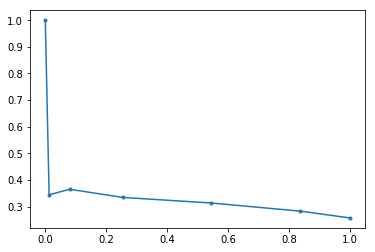

In [81]:
p.plot_precision_recall(pred_scores[:,1], y_test)

### EXPERIMENT WITH DIFFERENT PARAMETERS FOR THESE CLASSIFIERS

In [82]:
#1) Experiment with different parameters for these classifiers 
#(different values of k for example, as well as parameters that other classifiers have). 
#You should look at the sklearn documentation to see what parameter each classifier 
#can take and what the default values sklearn selects. The labs should be helpful here.

In [83]:
bagging = BaggingClassifier() # use the default parameters: base_estimator is a decision tree, n_estimators=10
bagging.fit(X_train_1, y_train_1)
pred_scores = bagging.predict_proba(X_test_1)

In [85]:
print("The true number of HBP is {}/{} from the testing data, with percentage {:.2f}%\n".format(
    sum(y_test), len(y_test), 100.*sum(y_test)/len(y_test)))
for threshold in np.linspace(0.1,0.7,7):
    pred_label = [1 if x[1]>threshold else 0 for x in pred_scores]
    print("(Threshold: {}), the total number of predicted HBP is {}, the accuracy is {:.2f}, the f1_score is {:.2f}".format(
        threshold, sum(pred_label), accuracy_score(pred_label,y_test), f1_score(y_test, pred_label)))
    print

The true number of HBP is 8431/32779 from the testing data, with percentage 25.72%

(Threshold: 0.1), the total number of predicted HBP is 24990, the accuracy is 0.42, the f1_score is 0.43
(Threshold: 0.2), the total number of predicted HBP is 19545, the accuracy is 0.52, the f1_score is 0.43
(Threshold: 0.3), the total number of predicted HBP is 14100, the accuracy is 0.60, the f1_score is 0.41
(Threshold: 0.4), the total number of predicted HBP is 9338, the accuracy is 0.66, the f1_score is 0.37
(Threshold: 0.5), the total number of predicted HBP is 5625, the accuracy is 0.70, the f1_score is 0.30
(Threshold: 0.6), the total number of predicted HBP is 2965, the accuracy is 0.72, the f1_score is 0.21
(Threshold: 0.7), the total number of predicted HBP is 1250, the accuracy is 0.74, the f1_score is 0.11


In [86]:
#based on runs above, threshold 4 is a good option - balance of accuracy and f_1

In [87]:
#now, let's use different models inside bagging
fpr, tpr, thresholds = roc_curve(y_test_1, pred_scores[:,1], pos_label=1)
print("The AUC under the original default setting of bagging is {:.3f}".format(auc(fpr, tpr)))

The AUC under the original default setting of bagging is 0.617


In [88]:
bagging = BaggingClassifier(base_estimator=LogisticRegression()) # use the default parameters: base_estimator is a decision tree, n_estimators=10
bagging.fit(X_train_1, y_train_1)
pred_scores = bagging.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(y_test_1, pred_scores[:,1], pos_label=1)
print("The AUC of bagging with Logistic Regression as base_estimator is {:.3f}".format(auc(fpr, tpr)))



The AUC of bagging with Logistic Regression as base_estimator is 0.603


In [89]:
#in this case, Logistic Regression does NOT improve the base estimator, as AUC goes down